In [1]:
import sys
import os

# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))
import numpy as np
import pandas as pd
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool, cpu_count
from ase import Atoms

import matplotlib.pyplot as plt
# Load the saved dataframe
df = pd.read_pickle(f"../dataset/symmetrized_dataset.pkl")

In [2]:
def kramers_kronig_tensor(omega_vals, imag_tensor):
    N = len(omega_vals)
    real_tensor = np.zeros_like(imag_tensor)

    for i in range(3):
        for j in range(i, 3):
            chi_im_vals = imag_tensor[:, i, j]
            chi_re_vals = np.zeros(N)

            for k, omega in enumerate(omega_vals):
                integrand = np.zeros(N)
                for l, omega_p in enumerate(omega_vals):
                    if l != k:  # Skip singularity
                        integrand[l] = (omega_p * chi_im_vals[l]) / (omega_p**2 - omega**2)
                integral = np.trapz(integrand, omega_vals)
                chi_re_vals[k] = (2 / np.pi) * integral

            real_tensor[:, i, j] = chi_re_vals
            if i != j:
                real_tensor[:, j, i] = chi_re_vals
    for i in range(3):
        real_tensor[:, i, i] += 1.0

    return real_tensor


In [3]:
import matplotlib.pyplot as plt

# Select a row by mp_id
row = df[df["mp_id"] == "mp-1219203"].iloc[0]

# Extract data
omega = row.omega
imag_permittivity = row["rel_permittivity_imag"]
real_permittivity = row["rel_permittivity_real"] 
real_permittivity_kkr = kramers_kronig_tensor(omega, imag_permittivity)


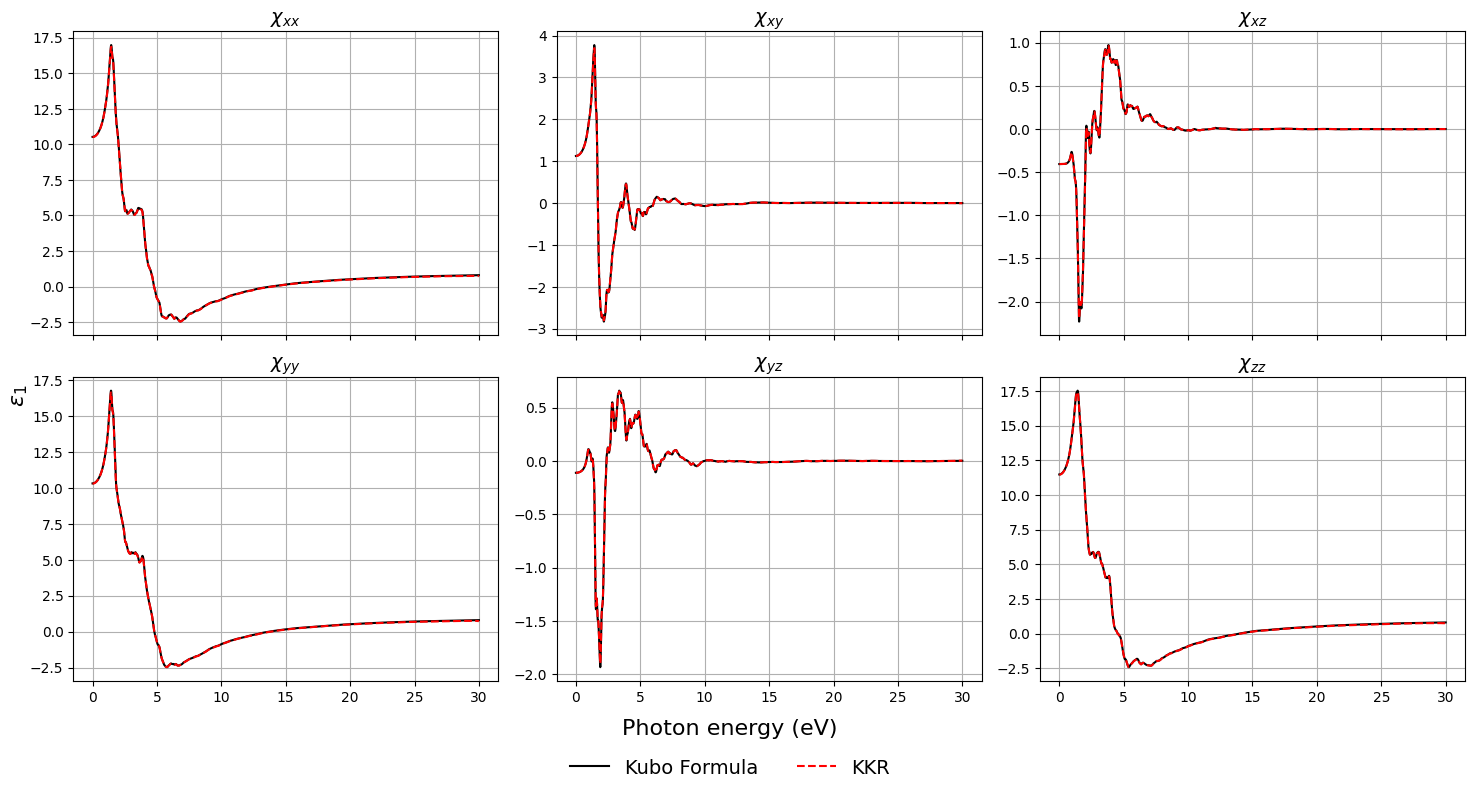

In [4]:
# Settings
xyz_list = ['x', 'y', 'z']
fontsize = 14
figsize = (15, 8)

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
axes = axes.flatten()

component_idx = 0
lines = []
labels = []

for i in range(3):
    for j in range(i, 3):
        ax = axes[component_idx]
        comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

        l1, = ax.plot(omega, real_permittivity[:, i, j], color='black', label='Kubo Formula')
        l2, = ax.plot(omega, real_permittivity_kkr[:, i, j], linestyle='--', color='red', label='KKR')

        ax.set_title(f"{comp_label}", fontsize=fontsize)
        ax.grid(True)

        if component_idx == 0:
            lines.extend([l1, l2])
            labels.extend([l.get_label() for l in (l1, l2)])

        component_idx += 1

# Hide unused subplots if any
for k in range(component_idx, len(axes)):
    fig.delaxes(axes[k])

# Super (global) axis labels
fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
fig.supylabel(r"$\epsilon_{1}$ ", fontsize=fontsize + 2)

# Shared legend below all plots
fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.0),frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
plt.show()
